In [1]:
import os
import ast
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.sans-serif"]=["WenQuanYi Micro Hei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

# 禁止随机，结果可复现
random.seed(42)
np.random.seed(42)

## 超参数选择

In [2]:
# Parameters
emo_index_id = 0
stage_id = 0
model_id = 0
data_number = 20

In [3]:
# Parameters
emo_index_id = 2
stage_id = 0
model_id = 1
data_number = 200


In [4]:
emo_index = ['上证综合情绪值', '沪深300情绪值', '创业板情绪值'][emo_index_id]
stage = ['计算矩阵', '读取矩阵'][stage_id]
model = ['Emo-Dict/DLUT', 'Emo-Dict/Bian', 'Emo-Dict/Jiang',
         'Machine-learning/LR', 'Machine-learning/RF', 'Machine-learning/SVM', 
         'Deep-learning/Separated_task'][model_id]

ROOT_PATH = '/data/public/fintechlab/zdh/Individual-Stock-Analysis/B_Temporal_Clustering'
Clustering_Method = 'Clustering_Based_on_Separation'
Emotion_Data_PATH = f'{ROOT_PATH}/data/Emotion_Data/{model}'   # 情绪数据路径
Financial_Data_PATH = f'{ROOT_PATH}/data/Financial_Data' # 金融数据路径

print(f"Running with: emo_index={emo_index}, stage={stage}, model={model}, data_number={data_number}")

Running with: emo_index=创业板情绪值, stage=计算矩阵, model=Emo-Dict/Bian, data_number=200


## 数据准备

In [5]:
"""读取股吧个股的数据"""
all_data = []
file_list = [f for f in os.listdir(Emotion_Data_PATH) if f.endswith('.csv')]

for file in file_list:
    file_path = os.path.join(Emotion_Data_PATH, file)
    df = pd.read_csv(file_path)
    stock_code = os.path.splitext(file)[0] # 获取股票编号（文件名去掉扩展名）
    
    # 提取每一行的日期和情绪值
    for _, row in df.iterrows():
        new_row = {
            '股票编号': stock_code,
            '日期': row['日期'],
            '上证综合情绪值': row['上证综合情绪值'],
            '沪深300情绪值': row['沪深300情绪值'],
            '创业板情绪值': row['创业板情绪值']
        }
        all_data.append(new_row)
        
guba_data = pd.DataFrame(all_data)
guba_data

,股票编号,日期,上证综合情绪值,沪深300情绪值,创业板情绪值
0,601933,2024-12-27,1.000000,1.000000,1.000000
1,601933,2024-11-18,0.000000,0.000000,0.000000
2,601933,2024-11-17,0.000000,0.000000,0.000000
3,601933,2024-11-17,0.000000,0.000000,0.000000
4,601933,2024-11-17,0.000000,0.000000,0.000000
...,...,...,...,...,...
495326,601919,2021-04-09,1.000000,1.000000,1.000000
495327,601919,2021-04-09,0.000000,0.000000,0.000000
495328,601919,2021-04-08,0.333333,0.333333,0.333333
495329,601919,2021-04-08,0.000000,0.000000,0.000000


In [6]:
"""读取股票回报率的数据"""
return_data = pd.read_csv(f'{Financial_Data_PATH}/日个股回报率.csv', dtype={'股票编号': str})
return_data

,股票编号,日期,交易量,收益率变化
0,000002,2021-06-01,60990961,-0.003745
1,000002,2021-06-02,85354506,0.006015
2,000002,2021-06-03,50594187,-0.003363
3,000002,2021-06-04,71422364,-0.012748
4,000002,2021-06-07,64745280,-0.014812
...,...,...,...,...
154877,688981,2024-11-20,58507495,-0.017071
154878,688981,2024-11-21,56197106,0.002358
154879,688981,2024-11-22,79240108,-0.050588
154880,688981,2024-11-25,76905909,-0.029402


In [7]:
# 进行左连接，guba_data 为主表
merged_data = pd.merge(guba_data, return_data[['股票编号', '日期', '交易量', '收益率变化']], 
                       on=['股票编号', '日期'], 
                       how='left')
merged_data = merged_data.dropna()
merged_data

,股票编号,日期,上证综合情绪值,沪深300情绪值,创业板情绪值,交易量,收益率变化
1,601933,2024-11-18,0.0,0.0,0.0,310012824.0,-0.004608
11,601933,2024-11-15,-1.0,-1.0,-1.0,423271473.0,-0.064655
12,601933,2024-11-15,0.0,0.0,0.0,423271473.0,-0.064655
13,601933,2024-11-14,0.0,0.0,0.0,372259052.0,-0.053061
14,601933,2024-11-14,0.0,0.0,0.0,372259052.0,-0.053061
...,...,...,...,...,...,...,...
495148,601919,2021-06-01,0.0,0.0,0.0,268816321.0,0.045859
495149,601919,2021-06-01,0.0,0.0,0.0,268816321.0,0.045859
495150,601919,2021-06-01,1.0,1.0,1.0,268816321.0,0.045859
495151,601919,2021-06-01,1.0,1.0,1.0,268816321.0,0.045859


## 数据预处理

In [8]:
# Step 1: 对情绪值列进行 Min-Max 标准化
def min_max_normalization(df, cols):
    for col in cols:
        min_val = df[col].min()
        max_val = df[col].max()
        df[col] = 2 * (df[col] - min_val) / (max_val - min_val) - 1
    return df

# Step 2: 对每个股票编号的数据进行标准化和按日期汇总
def process_data(df):
    df_processed = pd.DataFrame()  # 用于存储结果
    for stock_code, stock_data in df.groupby('股票编号'):
        # 对每个股票编号内的数据进行标准化
        stock_data = min_max_normalization(stock_data, ['上证综合情绪值', '沪深300情绪值', '创业板情绪值'])
        
        # 按日期汇总数据，同时保留股票编号
        stock_summary = stock_data.groupby('日期').agg({
            '股票编号': 'first',  # 保留股票编号（在同一日期内它是相同的，使用 'first'）
            '上证综合情绪值': 'mean',  # 上证综合情绪值按日期取均值
            '沪深300情绪值': 'mean',  # 沪深300情绪值按日期取均值
            '创业板情绪值': 'mean',  # 创业板情绪值按日期取均值
            '交易量': 'mean',  # 交易量按日期求和
            '收益率变化': 'mean'  # 收益率变化按日期取均值
        }).reset_index(drop=False)
        
        df_processed = pd.concat([df_processed, stock_summary], ignore_index=True)
    
    return df_processed

# 调用处理函数
final_data = process_data(merged_data)
final_data

,日期,股票编号,上证综合情绪值,沪深300情绪值,创业板情绪值,交易量,收益率变化
0,2021-06-01,000002,-0.500000,-0.500000,-0.500000,60990961.0,-0.003745
1,2021-06-08,000002,1.000000,1.000000,1.000000,44676494.0,0.004626
2,2021-06-10,000002,-0.333333,-0.333333,-0.333333,53800776.0,-0.010035
3,2021-06-11,000002,0.000000,0.000000,0.000000,75853738.0,-0.014035
4,2021-06-15,000002,-1.000000,-1.000000,-1.000000,89915501.0,-0.020957
...,...,...,...,...,...,...,...
85724,2024-11-12,688981,0.111111,0.111111,0.111111,108866759.0,-0.036864
85725,2024-11-13,688981,0.300000,0.300000,0.300000,80759477.0,-0.019484
85726,2024-11-14,688981,0.200000,0.200000,0.200000,76194102.0,-0.022897
85727,2024-11-15,688981,0.250000,0.250000,0.250000,71066743.0,-0.020233


## DTW 聚类

In [9]:
# 选择需要的列
dtw_df = final_data[['日期', '股票编号', emo_index, '收益率变化']]

# 按照股票编号和日期排序
dtw_df = dtw_df.sort_values(by=['股票编号', '日期'])

# 创建一个以股票编号为键，日期为时间序列的字典
stock_data = {}
if data_number > len(dtw_df['股票编号'].unique()):
    data_number = len(dtw_df['股票编号'].unique())
for stock in dtw_df['股票编号'].unique()[:data_number]:
    stock_data[stock] = dtw_df[dtw_df['股票编号'] == stock][['日期', emo_index, '收益率变化']].reset_index(drop=True)

In [10]:
if stage == '计算矩阵':
    from tqdm import tqdm
    from fastdtw import fastdtw
    from scipy.spatial.distance import euclidean
    
    # 假设stock_data已经准备好了，stock_ids包含所有股票编号
    stock_ids = list(stock_data.keys())
    dtw_distances = np.zeros((len(stock_ids), len(stock_ids)))
    
    # 使用 tqdm 包装外层循环以显示进度条
    for i, stock_i in tqdm(enumerate(stock_ids), total=len(stock_ids), desc="计算 DTW 距离", unit="股票"):
        for j, stock_j in enumerate(stock_ids):
            if i < j:
                series_i = stock_data[stock_i][[emo_index, '收益率变化']].values
                series_j = stock_data[stock_j][[emo_index, '收益率变化']].values
                distance, _ = fastdtw(series_i, series_j, dist=euclidean)
                dtw_distances[i, j] = distance
                dtw_distances[j, i] = distance  # 对称距离矩阵
    
    
    if emo_index == '上证综合情绪值':
        print(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_上证综合')
        os.makedirs(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_上证综合', exist_ok=True)
        np.save(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{model}/个股分析_上证综合/dtw_distances.npy', dtw_distances)
    if emo_index == '沪深300情绪值':
        os.makedirs(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_沪深300', exist_ok=True)
        np.save(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_沪深300/dtw_distances.npy', dtw_distances)
    if emo_index == '创业板情绪值':
        os.makedirs(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_创业板', exist_ok=True)
        np.save(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_创业板/dtw_distances.npy', dtw_distances)

计算 DTW 距离:   0%|          | 0/183 [00:00<?, ?股票/s]

计算 DTW 距离:   1%|          | 1/183 [00:16<49:18, 16.26s/股票]

计算 DTW 距离:   1%|          | 2/183 [00:24<34:23, 11.40s/股票]

计算 DTW 距离:   2%|▏         | 3/183 [00:40<40:31, 13.51s/股票]

计算 DTW 距离:   2%|▏         | 4/183 [00:50<36:21, 12.19s/股票]

计算 DTW 距离:   3%|▎         | 5/183 [01:06<40:15, 13.57s/股票]

计算 DTW 距离:   3%|▎         | 6/183 [01:21<41:11, 13.96s/股票]

计算 DTW 距离:   4%|▍         | 7/183 [01:30<36:56, 12.60s/股票]

计算 DTW 距离:   4%|▍         | 8/183 [01:46<39:11, 13.43s/股票]

计算 DTW 距离:   5%|▍         | 9/183 [02:01<40:47, 14.06s/股票]

计算 DTW 距离:   5%|▌         | 10/183 [02:15<40:14, 13.96s/股票]

计算 DTW 距离:   6%|▌         | 11/183 [02:26<37:13, 12.99s/股票]

计算 DTW 距离:   7%|▋         | 12/183 [02:39<37:24, 13.13s/股票]

计算 DTW 距离:   7%|▋         | 13/183 [02:54<38:40, 13.65s/股票]

计算 DTW 距离:   8%|▊         | 14/183 [03:09<39:22, 13.98s/股票]

计算 DTW 距离:   8%|▊         | 15/183 [03:18<35:13, 12.58s/股票]

计算 DTW 距离:   9%|▊         | 16/183 [03:25<29:54, 10.75s/股票]

计算 DTW 距离:   9%|▉         | 17/183 [03:34<28:47, 10.40s/股票]

计算 DTW 距离:  10%|▉         | 18/183 [03:43<27:26,  9.98s/股票]

计算 DTW 距离:  10%|█         | 19/183 [03:54<27:44, 10.15s/股票]

计算 DTW 距离:  11%|█         | 20/183 [04:04<27:46, 10.23s/股票]

计算 DTW 距离:  11%|█▏        | 21/183 [04:17<29:35, 10.96s/股票]

计算 DTW 距离:  12%|█▏        | 22/183 [04:27<29:05, 10.84s/股票]

计算 DTW 距离:  13%|█▎        | 23/183 [04:36<27:19, 10.25s/股票]

计算 DTW 距离:  13%|█▎        | 24/183 [04:46<26:50, 10.13s/股票]

计算 DTW 距离:  14%|█▎        | 25/183 [05:00<29:34, 11.23s/股票]

计算 DTW 距离:  14%|█▍        | 26/183 [05:14<31:20, 11.98s/股票]

计算 DTW 距离:  15%|█▍        | 27/183 [05:25<30:54, 11.89s/股票]

计算 DTW 距离:  15%|█▌        | 28/183 [05:37<30:39, 11.87s/股票]

计算 DTW 距离:  16%|█▌        | 29/183 [05:45<27:40, 10.78s/股票]

计算 DTW 距离:  16%|█▋        | 30/183 [05:56<27:24, 10.75s/股票]

计算 DTW 距离:  17%|█▋        | 31/183 [06:04<24:52,  9.82s/股票]

计算 DTW 距离:  17%|█▋        | 32/183 [06:14<24:53,  9.89s/股票]

计算 DTW 距离:  18%|█▊        | 33/183 [06:25<26:00, 10.40s/股票]

计算 DTW 距离:  19%|█▊        | 34/183 [06:37<26:46, 10.78s/股票]

计算 DTW 距离:  19%|█▉        | 35/183 [06:47<26:22, 10.69s/股票]

计算 DTW 距离:  20%|█▉        | 36/183 [07:00<27:21, 11.16s/股票]

计算 DTW 距离:  20%|██        | 37/183 [07:06<23:59,  9.86s/股票]

计算 DTW 距离:  21%|██        | 38/183 [07:16<23:40,  9.79s/股票]

计算 DTW 距离:  21%|██▏       | 39/183 [07:24<22:18,  9.30s/股票]

计算 DTW 距离:  22%|██▏       | 40/183 [07:30<19:42,  8.27s/股票]

计算 DTW 距离:  22%|██▏       | 41/183 [07:40<20:47,  8.79s/股票]

计算 DTW 距离:  23%|██▎       | 42/183 [07:51<21:51,  9.30s/股票]

计算 DTW 距离:  23%|██▎       | 43/183 [07:59<20:47,  8.91s/股票]

计算 DTW 距离:  24%|██▍       | 44/183 [08:04<18:28,  7.97s/股票]

计算 DTW 距离:  25%|██▍       | 45/183 [08:16<20:40,  8.99s/股票]

计算 DTW 距离:  25%|██▌       | 46/183 [08:23<18:58,  8.31s/股票]

计算 DTW 距离:  26%|██▌       | 47/183 [08:31<19:01,  8.40s/股票]

计算 DTW 距离:  26%|██▌       | 48/183 [08:38<18:08,  8.06s/股票]

计算 DTW 距离:  27%|██▋       | 49/183 [08:45<17:05,  7.65s/股票]

计算 DTW 距离:  27%|██▋       | 50/183 [08:55<18:17,  8.25s/股票]

计算 DTW 距离:  28%|██▊       | 51/183 [09:03<18:04,  8.22s/股票]

计算 DTW 距离:  28%|██▊       | 52/183 [09:12<18:21,  8.41s/股票]

计算 DTW 距离:  29%|██▉       | 53/183 [09:16<15:39,  7.23s/股票]

计算 DTW 距离:  30%|██▉       | 54/183 [09:22<14:26,  6.72s/股票]

计算 DTW 距离:  30%|███       | 55/183 [09:26<12:51,  6.03s/股票]

计算 DTW 距离:  31%|███       | 56/183 [09:31<12:18,  5.81s/股票]

计算 DTW 距离:  31%|███       | 57/183 [09:38<12:41,  6.04s/股票]

计算 DTW 距离:  32%|███▏      | 58/183 [09:43<12:06,  5.81s/股票]

计算 DTW 距离:  32%|███▏      | 59/183 [09:49<11:48,  5.71s/股票]

计算 DTW 距离:  33%|███▎      | 60/183 [09:55<11:55,  5.82s/股票]

计算 DTW 距离:  33%|███▎      | 61/183 [10:00<11:34,  5.69s/股票]

计算 DTW 距离:  34%|███▍      | 62/183 [10:04<10:36,  5.26s/股票]

计算 DTW 距离:  34%|███▍      | 63/183 [10:09<10:20,  5.17s/股票]

计算 DTW 距离:  35%|███▍      | 64/183 [10:17<11:25,  5.76s/股票]

计算 DTW 距离:  36%|███▌      | 65/183 [10:26<13:35,  6.91s/股票]

计算 DTW 距离:  36%|███▌      | 66/183 [10:33<13:30,  6.93s/股票]

计算 DTW 距离:  37%|███▋      | 67/183 [10:40<13:22,  6.92s/股票]

计算 DTW 距离:  37%|███▋      | 68/183 [10:44<11:44,  6.13s/股票]

计算 DTW 距离:  38%|███▊      | 69/183 [10:51<12:05,  6.36s/股票]

计算 DTW 距离:  38%|███▊      | 70/183 [10:58<12:22,  6.57s/股票]

计算 DTW 距离:  39%|███▉      | 71/183 [11:04<11:54,  6.38s/股票]

计算 DTW 距离:  39%|███▉      | 72/183 [11:11<11:47,  6.37s/股票]

计算 DTW 距离:  40%|███▉      | 73/183 [11:17<11:48,  6.44s/股票]

计算 DTW 距离:  40%|████      | 74/183 [11:22<10:59,  6.05s/股票]

计算 DTW 距离:  41%|████      | 75/183 [11:29<11:04,  6.15s/股票]

计算 DTW 距离:  42%|████▏     | 76/183 [11:33<10:08,  5.69s/股票]

计算 DTW 距离:  42%|████▏     | 77/183 [11:39<09:48,  5.55s/股票]

计算 DTW 距离:  43%|████▎     | 78/183 [11:47<11:05,  6.34s/股票]

计算 DTW 距离:  43%|████▎     | 79/183 [11:51<10:06,  5.83s/股票]

计算 DTW 距离:  44%|████▎     | 80/183 [11:59<10:56,  6.37s/股票]

计算 DTW 距离:  44%|████▍     | 81/183 [12:07<11:24,  6.71s/股票]

计算 DTW 距离:  45%|████▍     | 82/183 [12:14<11:33,  6.86s/股票]

计算 DTW 距离:  45%|████▌     | 83/183 [12:21<11:37,  6.97s/股票]

计算 DTW 距离:  46%|████▌     | 84/183 [12:27<11:03,  6.71s/股票]

计算 DTW 距离:  46%|████▋     | 85/183 [12:35<11:20,  6.94s/股票]

计算 DTW 距离:  47%|████▋     | 86/183 [12:42<11:35,  7.17s/股票]

计算 DTW 距离:  48%|████▊     | 87/183 [12:47<10:06,  6.32s/股票]

计算 DTW 距离:  48%|████▊     | 88/183 [12:54<10:23,  6.57s/股票]

计算 DTW 距离:  49%|████▊     | 89/183 [13:01<10:31,  6.71s/股票]

计算 DTW 距离:  49%|████▉     | 90/183 [13:06<09:43,  6.28s/股票]

计算 DTW 距离:  50%|████▉     | 91/183 [13:09<08:07,  5.30s/股票]

计算 DTW 距离:  50%|█████     | 92/183 [13:14<07:45,  5.11s/股票]

计算 DTW 距离:  51%|█████     | 93/183 [13:21<08:29,  5.66s/股票]

计算 DTW 距离:  51%|█████▏    | 94/183 [13:27<08:31,  5.74s/股票]

计算 DTW 距离:  52%|█████▏    | 95/183 [13:31<07:52,  5.37s/股票]

计算 DTW 距离:  52%|█████▏    | 96/183 [13:35<07:20,  5.06s/股票]

计算 DTW 距离:  53%|█████▎    | 97/183 [13:39<06:44,  4.70s/股票]

计算 DTW 距离:  54%|█████▎    | 98/183 [13:46<07:29,  5.29s/股票]

计算 DTW 距离:  54%|█████▍    | 99/183 [13:49<06:24,  4.58s/股票]

计算 DTW 距离:  55%|█████▍    | 100/183 [13:52<05:55,  4.29s/股票]

计算 DTW 距离:  55%|█████▌    | 101/183 [13:57<05:58,  4.38s/股票]

计算 DTW 距离:  56%|█████▌    | 102/183 [14:03<06:31,  4.83s/股票]

计算 DTW 距离:  56%|█████▋    | 103/183 [14:10<07:07,  5.35s/股票]

计算 DTW 距离:  57%|█████▋    | 104/183 [14:15<07:06,  5.40s/股票]

计算 DTW 距离:  57%|█████▋    | 105/183 [14:19<06:16,  4.83s/股票]

计算 DTW 距离:  58%|█████▊    | 106/183 [14:23<06:07,  4.77s/股票]

计算 DTW 距离:  58%|█████▊    | 107/183 [14:27<05:41,  4.49s/股票]

计算 DTW 距离:  59%|█████▉    | 108/183 [14:30<05:02,  4.03s/股票]

计算 DTW 距离:  60%|█████▉    | 109/183 [14:34<05:08,  4.17s/股票]

计算 DTW 距离:  60%|██████    | 110/183 [14:38<05:01,  4.12s/股票]

计算 DTW 距离:  61%|██████    | 111/183 [14:41<04:28,  3.74s/股票]

计算 DTW 距离:  61%|██████    | 112/183 [14:45<04:22,  3.70s/股票]

计算 DTW 距离:  62%|██████▏   | 113/183 [14:48<04:09,  3.57s/股票]

计算 DTW 距离:  62%|██████▏   | 114/183 [14:52<04:20,  3.77s/股票]

计算 DTW 距离:  63%|██████▎   | 115/183 [14:56<04:04,  3.59s/股票]

计算 DTW 距离:  63%|██████▎   | 116/183 [14:59<03:52,  3.47s/股票]

计算 DTW 距离:  64%|██████▍   | 117/183 [15:03<03:55,  3.57s/股票]

计算 DTW 距离:  64%|██████▍   | 118/183 [15:07<04:13,  3.89s/股票]

计算 DTW 距离:  65%|██████▌   | 119/183 [15:10<03:50,  3.60s/股票]

计算 DTW 距离:  66%|██████▌   | 120/183 [15:13<03:40,  3.49s/股票]

计算 DTW 距离:  66%|██████▌   | 121/183 [15:16<03:18,  3.21s/股票]

计算 DTW 距离:  67%|██████▋   | 122/183 [15:20<03:25,  3.37s/股票]

计算 DTW 距离:  67%|██████▋   | 123/183 [15:23<03:26,  3.44s/股票]

计算 DTW 距离:  68%|██████▊   | 124/183 [15:25<02:59,  3.05s/股票]

计算 DTW 距离:  68%|██████▊   | 125/183 [15:28<02:53,  2.99s/股票]

计算 DTW 距离:  69%|██████▉   | 126/183 [15:32<02:56,  3.10s/股票]

计算 DTW 距离:  69%|██████▉   | 127/183 [15:35<02:55,  3.14s/股票]

计算 DTW 距离:  70%|██████▉   | 128/183 [15:37<02:34,  2.82s/股票]

计算 DTW 距离:  70%|███████   | 129/183 [15:41<02:54,  3.24s/股票]

计算 DTW 距离:  71%|███████   | 130/183 [15:45<02:55,  3.32s/股票]

计算 DTW 距离:  72%|███████▏  | 131/183 [15:47<02:33,  2.96s/股票]

计算 DTW 距离:  72%|███████▏  | 132/183 [15:51<02:43,  3.21s/股票]

计算 DTW 距离:  73%|███████▎  | 133/183 [15:53<02:28,  2.96s/股票]

计算 DTW 距离:  73%|███████▎  | 134/183 [15:56<02:21,  2.90s/股票]

计算 DTW 距离:  74%|███████▍  | 135/183 [15:58<02:11,  2.74s/股票]

计算 DTW 距离:  74%|███████▍  | 136/183 [16:00<02:00,  2.57s/股票]

计算 DTW 距离:  75%|███████▍  | 137/183 [16:02<01:43,  2.25s/股票]

计算 DTW 距离:  75%|███████▌  | 138/183 [16:06<02:01,  2.71s/股票]

计算 DTW 距离:  76%|███████▌  | 139/183 [16:08<01:55,  2.63s/股票]

计算 DTW 距离:  77%|███████▋  | 140/183 [16:11<01:56,  2.71s/股票]

计算 DTW 距离:  77%|███████▋  | 141/183 [16:13<01:49,  2.61s/股票]

计算 DTW 距离:  78%|███████▊  | 142/183 [16:16<01:50,  2.71s/股票]

计算 DTW 距离:  78%|███████▊  | 143/183 [16:18<01:39,  2.48s/股票]

计算 DTW 距离:  79%|███████▊  | 144/183 [16:21<01:37,  2.50s/股票]

计算 DTW 距离:  79%|███████▉  | 145/183 [16:23<01:36,  2.54s/股票]

计算 DTW 距离:  80%|███████▉  | 146/183 [16:26<01:34,  2.54s/股票]

计算 DTW 距离:  80%|████████  | 147/183 [16:29<01:36,  2.68s/股票]

计算 DTW 距离:  81%|████████  | 148/183 [16:31<01:25,  2.44s/股票]

计算 DTW 距离:  81%|████████▏ | 149/183 [16:33<01:18,  2.30s/股票]

计算 DTW 距离:  82%|████████▏ | 150/183 [16:35<01:12,  2.21s/股票]

计算 DTW 距离:  83%|████████▎ | 151/183 [16:37<01:10,  2.21s/股票]

计算 DTW 距离:  83%|████████▎ | 152/183 [16:39<01:02,  2.02s/股票]

计算 DTW 距离:  84%|████████▎ | 153/183 [16:40<00:59,  1.97s/股票]

计算 DTW 距离:  84%|████████▍ | 154/183 [16:42<00:52,  1.81s/股票]

计算 DTW 距离:  85%|████████▍ | 155/183 [16:43<00:48,  1.74s/股票]

计算 DTW 距离:  85%|████████▌ | 156/183 [16:45<00:47,  1.75s/股票]

计算 DTW 距离:  86%|████████▌ | 157/183 [16:47<00:46,  1.77s/股票]

计算 DTW 距离:  86%|████████▋ | 158/183 [16:48<00:41,  1.66s/股票]

计算 DTW 距离:  87%|████████▋ | 159/183 [16:50<00:38,  1.62s/股票]

计算 DTW 距离:  87%|████████▋ | 160/183 [16:51<00:31,  1.38s/股票]

计算 DTW 距离:  88%|████████▊ | 161/183 [16:52<00:29,  1.35s/股票]

计算 DTW 距离:  89%|████████▊ | 162/183 [16:54<00:29,  1.41s/股票]

计算 DTW 距离:  89%|████████▉ | 163/183 [16:55<00:26,  1.33s/股票]

计算 DTW 距离:  90%|████████▉ | 164/183 [16:56<00:25,  1.35s/股票]

计算 DTW 距离:  90%|█████████ | 165/183 [16:57<00:21,  1.22s/股票]

计算 DTW 距离:  91%|█████████ | 166/183 [16:59<00:22,  1.29s/股票]

计算 DTW 距离:  91%|█████████▏| 167/183 [17:00<00:19,  1.21s/股票]

计算 DTW 距离:  92%|█████████▏| 168/183 [17:00<00:16,  1.13s/股票]

计算 DTW 距离:  92%|█████████▏| 169/183 [17:01<00:14,  1.03s/股票]

计算 DTW 距离:  93%|█████████▎| 170/183 [17:02<00:12,  1.06股票/s]

计算 DTW 距离:  93%|█████████▎| 171/183 [17:02<00:09,  1.24股票/s]

计算 DTW 距离:  94%|█████████▍| 172/183 [17:03<00:07,  1.44股票/s]

计算 DTW 距离:  95%|█████████▍| 173/183 [17:03<00:06,  1.53股票/s]

计算 DTW 距离:  95%|█████████▌| 174/183 [17:04<00:05,  1.76股票/s]

计算 DTW 距离:  96%|█████████▌| 175/183 [17:04<00:04,  1.75股票/s]

计算 DTW 距离:  96%|█████████▌| 176/183 [17:05<00:03,  1.97股票/s]

计算 DTW 距离:  97%|█████████▋| 177/183 [17:05<00:02,  2.21股票/s]

计算 DTW 距离:  97%|█████████▋| 178/183 [17:05<00:01,  2.64股票/s]

计算 DTW 距离:  98%|█████████▊| 179/183 [17:06<00:01,  2.79股票/s]

计算 DTW 距离:  98%|█████████▊| 180/183 [17:06<00:00,  3.43股票/s]

计算 DTW 距离:  99%|█████████▉| 182/183 [17:06<00:00,  5.29股票/s]

计算 DTW 距离: 100%|██████████| 183/183 [17:06<00:00,  5.61s/股票]

In [11]:
# 读取 DTW 距离矩阵
stock_ids = list(stock_data.keys())
if emo_index == '上证综合情绪值':
    dtw_distances = np.load(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_上证综合/dtw_distances.npy')
if emo_index == '沪深300情绪值':
    dtw_distances = np.load(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_沪深300/dtw_distances.npy')
if emo_index == '创业板情绪值':
    dtw_distances = np.load(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_创业板/dtw_distances.npy')

In [12]:
from sklearn.cluster import KMeans

# KMeans 聚类
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(dtw_distances)

# 查看每个股票的聚类结果
stock_clusters = {stock_ids[i]: clusters[i] for i in range(len(stock_ids))}

# 创建一个 DataFrame 来保存股票编号与对应的聚类标签
stock_clusters_df = pd.DataFrame({
    '股票编号': stock_ids,
    '聚类标签': clusters
})
if emo_index == '上证综合情绪值':
    stock_clusters_df.to_csv(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_上证综合/clusters_results.csv', index=False, encoding='utf-8')
if emo_index == '沪深300情绪值':
    stock_clusters_df.to_csv(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_沪深300/clusters_results.csv', index=False, encoding='utf-8')
if emo_index == '创业板情绪值':
    stock_clusters_df.to_csv(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_创业板/clusters_results.csv', index=False, encoding='utf-8')
stock_clusters


{'000002': np.int32(2),
 '000061': np.int32(1),
 '000063': np.int32(2),
 '000069': np.int32(0),
 '000100': np.int32(2),
 '000333': np.int32(2),
 '000513': np.int32(1),
 '000625': np.int32(2),
 '000651': np.int32(2),
 '000661': np.int32(2),
 '000681': np.int32(0),
 '000723': np.int32(2),
 '000725': np.int32(2),
 '000858': np.int32(2),
 '000895': np.int32(1),
 '000910': np.int32(1),
 '000937': np.int32(0),
 '000999': np.int32(0),
 '001979': np.int32(0),
 '002008': np.int32(0),
 '002024': np.int32(2),
 '002065': np.int32(0),
 '002142': np.int32(0),
 '002202': np.int32(0),
 '002230': np.int32(2),
 '002241': np.int32(2),
 '002271': np.int32(2),
 '002304': np.int32(2),
 '002368': np.int32(0),
 '002371': np.int32(2),
 '002387': np.int32(1),
 '002415': np.int32(0),
 '002460': np.int32(2),
 '002466': np.int32(2),
 '002475': np.int32(2),
 '002594': np.int32(2),
 '003816': np.int32(1),
 '300002': np.int32(2),
 '300003': np.int32(0),
 '300012': np.int32(1),
 '300014': np.int32(2),
 '300015': np.in

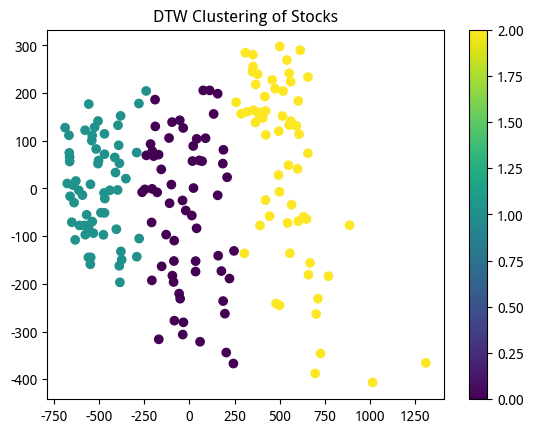

In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 使用PCA将高维的DTW距离降到2D
pca = PCA(n_components=2)
dtw_distances_2d = pca.fit_transform(dtw_distances)

# 创建聚类结果的散点图
plt.scatter(dtw_distances_2d[:, 0], dtw_distances_2d[:, 1], c=clusters, cmap='viridis')
plt.colorbar()
plt.title('DTW Clustering of Stocks')
if emo_index == '上证综合情绪值':
    plt.savefig(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_上证综合/DTW_Clustering_of_Stocks3')
if emo_index == '沪深300情绪值':
    plt.savefig(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_沪深300/DTW_Clustering_of_Stocks3')
if emo_index == '创业板情绪值':
    plt.savefig(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_创业板/DTW_Clustering_of_Stocks3')
plt.show()


In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.dates as mdates

# 假设 final_data 已经加载并经过清洗处理
merged_data_cleaned = final_data.copy()

# 将日期列转换为 datetime 类型（确保时间格式正确）
merged_data_cleaned['日期'] = pd.to_datetime(merged_data_cleaned['日期'])

# 设置绘图窗口，一行三列的子图
fig, axes = plt.subplots(3, 1, figsize=(50, 50), subplot_kw={'projection': '3d'})

# 情绪值列名列表
emotion_columns = ['上证综合情绪值', '沪深300情绪值', '创业板情绪值']

# 遍历每个情绪值列
for i, emotion_col in enumerate(emotion_columns):
    ax = axes[i]
    
    # 按股票编号分组
    for stock_code, stock_data in merged_data_cleaned.groupby('股票编号'):
        if stock_code == '000002':  # 如果只关心股票编号为 '000002'
            # 对每个股票编号绘制三维折线图
            x = stock_data[emotion_col]  # 情绪值作为 x 轴
            y = mdates.date2num(stock_data['日期'])  # 时间转换为数值类型，用于 y 轴
            z = stock_data['收益率变化']  # 收益率变化作为 z 轴
            
            # 绘制三维折线图
            ax.plot(x, y, z, label=f"股票 {stock_code}", marker='o', linestyle='-', alpha=0.7)

    # 设置图表标签
    ax.set_xlabel(emotion_col)
    ax.set_ylabel('时间')
    ax.set_zlabel('收益率变化')
    ax.set_title(f'{emotion_col} 与收益率变化的三维关系')

    # 设置 y 轴显示为半年显示一次
    ax.yaxis.set_major_locator(mdates.MonthLocator(bymonthday=15, interval=6))  # 每半年一个刻度
    ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 按年月显示

    # 自动旋转日期标签，防止重叠
    fig.autofmt_xdate()

# 调整布局
plt.tight_layout()
plt.savefig(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/万科A情绪股价时间序列数据')
# plt.show()
plt.close()

/tmp/ipykernel_2043447/3646053049.py:46: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


## 数据集成

In [15]:
import pandas as pd

# 读取两个CSV文件
if emo_index == '上证综合情绪值':
    cluster_df = pd.read_csv(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_上证综合/clusters_results.csv', dtype={'股票编号': str})
if emo_index == '沪深300情绪值':
    cluster_df = pd.read_csv(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_沪深300/clusters_results.csv', dtype={'股票编号': str})
if emo_index == '创业板情绪值':
    cluster_df = pd.read_csv(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_创业板/clusters_results.csv', dtype={'股票编号': str})
company_info_df = pd.read_csv(f'{Financial_Data_PATH}/中国公司代码.csv', dtype={'Stkcd': str})  # 假设第二个文件名为company_info.csv

# 重命名列名，统一为 'Stkcd' 以便合并
cluster_df = cluster_df.rename(columns={'股票编号': 'Stkcd'})

# 显式统一合并键的数据类型
cluster_df['Stkcd'] = cluster_df['Stkcd'].astype(str)
company_info_df['Stkcd'] = company_info_df['Stkcd'].astype(str)

# 合并前清除可能重复的列，防止冲突
if 'Stknme' in cluster_df.columns:
    cluster_df = cluster_df.drop(columns=['Stknme'])

# 安全合并
merged_df = pd.merge(cluster_df, company_info_df[['Stkcd', 'Stknme']], on='Stkcd', how='left')

if emo_index == '上证综合情绪值':
    merged_df.to_csv(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_上证综合/clusters_results.csv', index=False)
if emo_index == '沪深300情绪值':
    merged_df.to_csv(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_沪深300/clusters_results.csv', index=False)
if emo_index == '创业板情绪值':
    merged_df.to_csv(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_创业板/clusters_results.csv', index=False)

merged_df


,Stkcd,聚类标签,Stknme
0,000002,2,万科A
1,000061,1,农产品
2,000063,2,中兴通讯
3,000069,0,华侨城A
4,000100,2,TCL科技
...,...,...,...
178,603986,2,兆易创新
179,688005,1,容百科技
180,688027,1,国盾量子
181,688029,1,南微医学
